In [10]:
# ==============================
# Импорты и настройки устройства
# ==============================
import os, sys, math, random, json, time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from glob import glob
from PIL import Image
from collections import defaultdict
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    print('✓ GPU is available. Using CUDA')
else:
    print('⚠ Using CPU')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

✓ GPU is available. Using CUDA


In [11]:
# ==============================
# Конфиг
# ==============================
ROOT_DIR = 'kvasir-dataset-v2'  # корень датасета (классы = подпапки)

# Обучение teacher linear probe
TEACHER_LR = 5e-4
TEACHER_EPOCHS = 5

# Обучение студента с KD
KD_LR = 1e-4
KD_EPOCHS = 10
BATCH_SIZE = 16
NUM_WORKERS = 0  # для Windows 0 безопаснее

# KD гиперпараметры
TEMPERATURE = 4.0
KD_ALPHA = 0.7  # вес KD (KL); (1-KD_ALPHA) — вес CE по меткам

SAVE_BEST = True

In [12]:
cd perception_models

[WinError 2] Не удается найти указанный файл: 'perception_models'
c:\Users\amirn\OneDrive\Рабочий стол\Optimization\perception_models


In [13]:
from core.vision_encoder import pe
from core.vision_encoder import transforms

print('Загружаем модель-учителя PE-Core-L14-336...')
teacher_model = pe.CLIP.from_config('PE-Core-L14-336', pretrained=True).to(device).float().eval()

print('Загружаем модель-студента PE-Core-S16-384...')
student_model = pe.CLIP.from_config('PE-Core-S16-384', pretrained=True).to(device).float()

teacher_preprocessor = transforms.get_image_transform(teacher_model.image_size)
student_preprocessor = transforms.get_image_transform(student_model.image_size)
teacher_dim = teacher_model.visual.output_dim
student_dim = student_model.visual.output_dim

print(f'Размеры: teacher_img={teacher_model.image_size}, student_img={student_model.image_size}')
print(f'Dims: teacher={teacher_dim}, student={student_dim}')

Загружаем модель-учителя PE-Core-L14-336...
Missing keys for loading model: []
Unexpected keys for loading model: []
Загружаем модель-студента PE-Core-S16-384...
Missing keys for loading model: []
Unexpected keys for loading model: []
Размеры: teacher_img=336, student_img=384
Dims: teacher=1024, student=512


In [14]:
cd ..

c:\Users\amirn\OneDrive\Рабочий стол\Optimization


In [15]:
# ==============================
# Подготовка датасета
# ==============================
def extract_label_from_path(image_path, root_dir):
    parts = Path(image_path).parts
    try:
        ridx = parts.index(Path(root_dir).name)
        return parts[ridx + 1]
    except (ValueError, IndexError):
        return None

print('Ищем изображения...')
all_image_paths = glob(os.path.join(ROOT_DIR, '**', '*.jpg'), recursive=True)
print(f'Найдено {len(all_image_paths)} jpg-файлов')

image_to_path, image_to_label = {}, {}
for p in all_image_paths:
    image_id = os.path.splitext(os.path.basename(p))[0]
    label = extract_label_from_path(p, ROOT_DIR)
    if label is not None:
        image_to_path[image_id] = p
        image_to_label[image_id] = label

print(f'Валидных изображений: {len(image_to_label)}')

classes = sorted(list(set(image_to_label.values())))
label_to_idx = {c: i for i, c in enumerate(classes)}
idx_to_label = {i: c for c, i in label_to_idx.items()}
print(f'Классов: {len(classes)} -> {classes}')

# Опционально — сбалансированное подмножество
images_by_class = defaultdict(list)
for img_id, lbl in image_to_label.items():
    images_by_class[lbl].append(img_id)

images_per_class = 500  # при нехватке возьмется меньше
sampled = []
for lbl, ids in images_by_class.items():
    k = min(images_per_class, len(ids))
    sampled.extend(random.sample(ids, k))
random.shuffle(sampled)
print(f'Подмножество: {len(sampled)} изображений')

labels_for_strat = [image_to_label[i] for i in sampled]
train_val_ids, test_ids = train_test_split(sampled, test_size=0.20, stratify=labels_for_strat, random_state=SEED)
train_labels_for_strat = [image_to_label[i] for i in train_val_ids]
train_ids, val_ids = train_test_split(train_val_ids, test_size=0.20, stratify=train_labels_for_strat, random_state=SEED)

print(f'Train: {len(train_ids)}  Val: {len(val_ids)}  Test: {len(test_ids)}')

Ищем изображения...
Найдено 8000 jpg-файлов
Валидных изображений: 7999
Классов: 8 -> ['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']
Подмножество: 4000 изображений
Train: 2560  Val: 640  Test: 800


In [16]:
# ==============================
# Dataset и DataLoader
# ==============================
class KDDataset(Dataset):
    def __init__(self, image_ids, image_to_path, image_to_label, label_to_idx, t_transform, s_transform):
        self.ids = image_ids
        self.image_to_path = image_to_path
        self.image_to_label = image_to_label
        self.label_to_idx = label_to_idx
        self.t_transform = t_transform
        self.s_transform = s_transform
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, idx):
        img_id = self.ids[idx]
        path = self.image_to_path[img_id]
        label = self.image_to_label[img_id]
        y = self.label_to_idx[label]
        img = Image.open(path).convert('RGB')
        x_t = self.t_transform(img)
        x_s = self.s_transform(img)
        return x_t, x_s, torch.tensor(y, dtype=torch.long)

train_ds = KDDataset(train_ids, image_to_path, image_to_label, label_to_idx, teacher_preprocessor, student_preprocessor)
val_ds   = KDDataset(val_ids,   image_to_path, image_to_label, label_to_idx, teacher_preprocessor, student_preprocessor)
test_ds  = KDDataset(test_ids,  image_to_path, image_to_label, label_to_idx, teacher_preprocessor, student_preprocessor)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=torch.cuda.is_available())
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=torch.cuda.is_available())
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=torch.cuda.is_available())

print('✓ DataLoaders готовы')

✓ DataLoaders готовы


In [17]:
# ==============================
# Головы классификации
# ==============================
class LinearHead(nn.Module):
    def __init__(self, in_dim, num_classes):
        super().__init__()
        self.fc = nn.Linear(in_dim, num_classes)
    def forward(self, x):
        return self.fc(x)

num_classes = len(classes)
teacher_head = LinearHead(teacher_dim, num_classes).to(device)
student_head = LinearHead(student_dim, num_classes).to(device)
print(f'Инициализированы головы: teacher_head {teacher_dim}->{num_classes}, student_head {student_dim}->{num_classes}')

Инициализированы головы: teacher_head 1024->8, student_head 512->8


In [18]:
# ==============================
# Обучение teacher linear probe
# ==============================
def evaluate_head(model, head, loader, device):
    model.eval(); head.eval()
    correct, total, loss_sum, n_batches = 0, 0, 0.0, 0
    ce = nn.CrossEntropyLoss()
    with torch.no_grad():
        for x_t, _, y in loader:
            x_t = x_t.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            feats = model.encode_image(x_t)
            logits = head(feats)
            loss = ce(logits, y)
            _, pred = torch.max(logits, 1)
            total += y.size(0)
            correct += (pred == y).sum().item()
            loss_sum += loss.item()
            n_batches += 1
    acc = 100.0 * correct / total if total > 0 else 0.0
    return (loss_sum / max(1, n_batches)), acc

def train_teacher_probe(model, head, train_loader, val_loader, epochs=TEACHER_EPOCHS, lr=TEACHER_LR):
    for p in model.parameters():
        p.requires_grad = False
    head.train()
    opt = torch.optim.AdamW(head.parameters(), lr=lr, weight_decay=1e-5)
    ce = nn.CrossEntropyLoss()
    best_val_acc, best_state = -1.0, None
    for ep in range(1, epochs + 1):
        head.train()
        loss_sum, n_batches, correct, total = 0.0, 0, 0, 0
        for x_t, _, y in train_loader:
            x_t = x_t.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            with torch.no_grad():
                feats = model.encode_image(x_t)
            logits = head(feats)
            loss = ce(logits, y)
            opt.zero_grad()
            loss.backward()
            opt.step()
            _, pred = torch.max(logits, 1)
            total += y.size(0)
            correct += (pred == y).sum().item()
            loss_sum += loss.item()
            n_batches += 1
        train_acc = 100.0 * correct / total if total > 0 else 0.0
        val_loss, val_acc = evaluate_head(model, head, val_loader, device)
        print(f'[Teacher Probe] Epoch {ep}/{epochs} | TrainAcc {train_acc:.2f}% | ValAcc {val_acc:.2f}% | ValLoss {val_loss:.4f}')
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = head.state_dict()
    if best_state is not None:
        head.load_state_dict(best_state)
    for p in head.parameters():
        p.requires_grad = False
    head.eval()
    torch.save({'state_dict': head.state_dict(), 'num_classes': num_classes}, 'teacher_linear_probe.pth')
    print(f'✓ Сохранен teacher linear probe (ValAcc={best_val_acc:.2f}%)')

train_teacher_probe(teacher_model, teacher_head, train_loader, val_loader)

[Teacher Probe] Epoch 1/5 | TrainAcc 68.20% | ValAcc 85.31% | ValLoss 0.6211
[Teacher Probe] Epoch 2/5 | TrainAcc 85.20% | ValAcc 87.81% | ValLoss 0.4562
[Teacher Probe] Epoch 3/5 | TrainAcc 87.70% | ValAcc 87.19% | ValLoss 0.3896
[Teacher Probe] Epoch 4/5 | TrainAcc 87.93% | ValAcc 90.31% | ValLoss 0.3326
[Teacher Probe] Epoch 5/5 | TrainAcc 88.91% | ValAcc 87.19% | ValLoss 0.3582
✓ Сохранен teacher linear probe (ValAcc=90.31%)


In [19]:
# ==============================
# KD Loss (KL с температурой) + CE
# ==============================
class KDLoss(nn.Module):
    def __init__(self, temperature=4.0, alpha=0.7):
        super().__init__()
        self.T = temperature
        self.alpha = alpha
        self.kl = nn.KLDivLoss(reduction='batchmean')
        self.ce = nn.CrossEntropyLoss()
    def forward(self, student_logits, teacher_logits, labels):
        T = self.T
        kd = self.kl(F.log_softmax(student_logits / T, dim=-1),
                     F.softmax(teacher_logits / T, dim=-1)) * (T * T)
        ce = self.ce(student_logits, labels)
        total = self.alpha * kd + (1.0 - self.alpha) * ce
        return total, kd, ce

kd_criterion = KDLoss(temperature=TEMPERATURE, alpha=KD_ALPHA)
print('✓ KD критерий инициализирован')

✓ KD критерий инициализирован


In [20]:
# ==============================
# Валидация студента
# ==============================
def validate_student(student_model, student_head, teacher_model, teacher_head, loader, criterion, device):
    student_model.eval(); student_head.eval()
    teacher_model.eval(); teacher_head.eval()
    total_loss = total_kd = total_ce = 0.0
    correct = total = n_batches = 0
    with torch.no_grad():
        for x_t, x_s, y in loader:
            x_t = x_t.to(device, non_blocking=True)
            x_s = x_s.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            # Логиты учителя (фрозен)
            t_feat = teacher_model.encode_image(x_t)
            t_logits = teacher_head(t_feat)

            # Логиты студента
            s_feat = student_model.encode_image(x_s)
            s_logits = student_head(s_feat)

            loss, kd, ce = criterion(s_logits, t_logits, y)
            total_loss += loss.item()
            total_kd += kd.item()
            total_ce += ce.item()
            _, pred = torch.max(s_logits, 1)
            total += y.size(0)
            correct += (pred == y).sum().item()
            n_batches += 1
    avg_loss = total_loss / max(1, n_batches)
    avg_kd = total_kd / max(1, n_batches)
    avg_ce = total_ce / max(1, n_batches)
    acc = 100.0 * correct / total if total > 0 else 0.0
    return avg_loss, avg_kd, avg_ce, acc

In [21]:
# ==============================
# Тренировка студента с KD
# ==============================
optimizer = torch.optim.AdamW(list(student_model.parameters()) + list(student_head.parameters()), lr=KD_LR, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=KD_EPOCHS)

history = {
    'train_loss': [], 'train_kd': [], 'train_ce': [],
    'val_loss': [], 'val_kd': [], 'val_ce': [], 'val_acc': []
}
best_val_acc, best_state = -1.0, None

print('\n' + '='*80)
print('НАЧАЛО ОБУЧЕНИЯ С ЛОГИТ-ДИСТИЛЛЯЦИЕЙ (KD)')
print('='*80 + '\n')

for epoch in range(1, KD_EPOCHS + 1):
    student_model.train(); student_head.train()
    teacher_model.eval(); teacher_head.eval()
    loss_sum = kd_sum = ce_sum = 0.0
    n_batches = 0

    for x_t, x_s, y in DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=torch.cuda.is_available()):
        x_t = x_t.to(device, non_blocking=True)
        x_s = x_s.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        with torch.no_grad():
            t_feat = teacher_model.encode_image(x_t)
            t_logits = teacher_head(t_feat)

        s_feat = student_model.encode_image(x_s)
        s_logits = student_head(s_feat)

        loss, kd, ce = kd_criterion(s_logits, t_logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        kd_sum += kd.item()
        ce_sum += ce.item()
        n_batches += 1

    avg_train_loss = loss_sum / max(1, n_batches)
    avg_train_kd = kd_sum / max(1, n_batches)
    avg_train_ce = ce_sum / max(1, n_batches)

    val_loss, val_kd, val_ce, val_acc = validate_student(student_model, student_head, teacher_model, teacher_head, val_loader, kd_criterion, device)
    scheduler.step()

    history['train_loss'].append(avg_train_loss)
    history['train_kd'].append(avg_train_kd)
    history['train_ce'].append(avg_train_ce)
    history['val_loss'].append(val_loss)
    history['val_kd'].append(val_kd)
    history['val_ce'].append(val_ce)
    history['val_acc'].append(val_acc)

    print(f'Epoch {epoch}/{KD_EPOCHS} | Train: loss={avg_train_loss:.4f} kd={avg_train_kd:.4f} ce={avg_train_ce:.4f} | Val: loss={val_loss:.4f} kd={val_kd:.4f} ce={val_ce:.4f} acc={val_acc:.2f}%')

    if SAVE_BEST and val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = {
            'student_model': student_model.state_dict(),
            'student_head': student_head.state_dict(),
            'epoch': epoch,
            'val_acc': val_acc
        }
        torch.save(best_state, 'student_kd_best.pth')
        print(f'  ✓ Сохранена лучшая модель (ValAcc={val_acc:.2f}%)')

print('\nЗавершено обучение KD. Лучшая ValAcc:', f'{best_val_acc:.2f}%')


НАЧАЛО ОБУЧЕНИЯ С ЛОГИТ-ДИСТИЛЛЯЦИЕЙ (KD)

Epoch 1/10 | Train: loss=1.1145 kd=1.2391 ce=0.8238 | Val: loss=0.6610 kd=0.7301 ce=0.4997 acc=78.44%
  ✓ Сохранена лучшая модель (ValAcc=78.44%)
Epoch 2/10 | Train: loss=0.5802 kd=0.6330 ce=0.4568 | Val: loss=0.8283 kd=0.8982 ce=0.6651 acc=73.59%
Epoch 3/10 | Train: loss=0.4392 kd=0.4807 ce=0.3423 | Val: loss=0.4226 kd=0.4640 ce=0.3258 acc=89.06%
  ✓ Сохранена лучшая модель (ValAcc=89.06%)
Epoch 4/10 | Train: loss=0.3128 kd=0.3372 ce=0.2559 | Val: loss=0.3927 kd=0.4362 ce=0.2914 acc=89.38%
  ✓ Сохранена лучшая модель (ValAcc=89.38%)
Epoch 5/10 | Train: loss=0.2546 kd=0.2665 ce=0.2268 | Val: loss=0.3766 kd=0.4117 ce=0.2948 acc=88.75%
Epoch 6/10 | Train: loss=0.2101 kd=0.2105 ce=0.2090 | Val: loss=0.3347 kd=0.3622 ce=0.2705 acc=90.31%
  ✓ Сохранена лучшая модель (ValAcc=90.31%)
Epoch 7/10 | Train: loss=0.1702 kd=0.1599 ce=0.1942 | Val: loss=0.3299 kd=0.3563 ce=0.2681 acc=90.94%
  ✓ Сохранена лучшая модель (ValAcc=90.94%)
Epoch 8/10 | Train: lo

In [22]:
# ==============================
# Тестирование
# ==============================
def test_student(student_model, student_head, loader, device):
    student_model.eval(); student_head.eval()
    correct, total = 0, 0
    class_correct = defaultdict(int)
    class_total = defaultdict(int)
    with torch.no_grad():
        for _, x_s, y in loader:
            x_s = x_s.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            s_feat = student_model.encode_image(x_s)
            logits = student_head(s_feat)
            _, pred = torch.max(logits, 1)
            total += y.size(0)
            correct += (pred == y).sum().item()
            for i in range(y.size(0)):
                cls_name = idx_to_label[y[i].item()]
                class_total[cls_name] += 1
                if pred[i] == y[i]:
                    class_correct[cls_name] += 1
    acc = 100.0 * correct / total if total > 0 else 0.0
    return acc, class_correct, class_total

test_acc, class_correct, class_total = test_student(student_model, student_head, test_loader, device)
print(f'Test Accuracy: {test_acc:.2f}%')
print('Accuracy по классам:')
for cls in sorted(class_total.keys()):
    acc_c = 100.0 * class_correct[cls] / class_total[cls] if class_total[cls] > 0 else 0.0
    print(f'  {cls}: {acc_c:.2f}% ({class_correct[cls]}/{class_total[cls]})')

torch.save({
    'student_model': student_model.state_dict(),
    'student_head': student_head.state_dict(),
    'classes': classes,
    'label_to_idx': label_to_idx,
    'idx_to_label': idx_to_label,
    'teacher_dim': teacher_dim,
    'student_dim': student_dim,
    'num_classes': num_classes,
    'history': history
}, 'student_kd_final.pth')
print('✓ Финальная модель сохранена: student_kd_final.pth')

Test Accuracy: 90.00%
Accuracy по классам:
  dyed-lifted-polyps: 98.00% (98/100)
  dyed-resection-margins: 79.00% (79/100)
  esophagitis: 78.00% (78/100)
  normal-cecum: 97.00% (97/100)
  normal-pylorus: 98.00% (98/100)
  normal-z-line: 88.00% (88/100)
  polyps: 91.00% (91/100)
  ulcerative-colitis: 91.00% (91/100)
✓ Финальная модель сохранена: student_kd_final.pth


📈 История обучения сохранена: training_history_kd.png


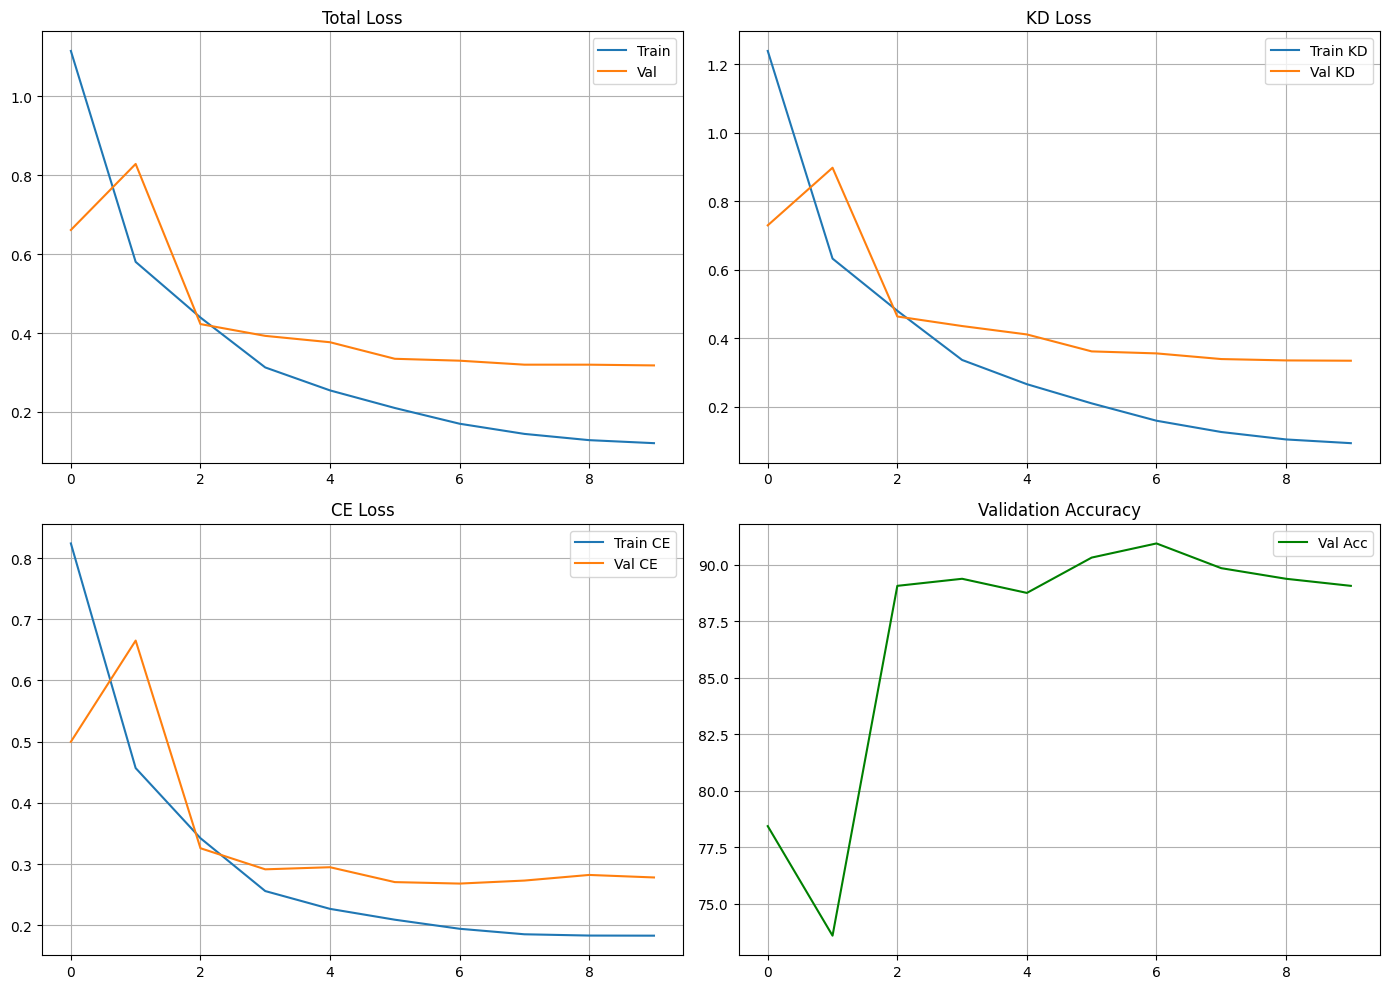

In [23]:
# ==============================
# Визуализация метрик
# ==============================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes[0,0].plot(history['train_loss'], label='Train'); axes[0,0].plot(history['val_loss'], label='Val'); axes[0,0].set_title('Total Loss'); axes[0,0].legend(); axes[0,0].grid(True)
axes[0,1].plot(history['train_kd'], label='Train KD'); axes[0,1].plot(history['val_kd'], label='Val KD'); axes[0,1].set_title('KD Loss'); axes[0,1].legend(); axes[0,1].grid(True)
axes[1,0].plot(history['train_ce'], label='Train CE'); axes[1,0].plot(history['val_ce'], label='Val CE'); axes[1,0].set_title('CE Loss'); axes[1,0].legend(); axes[1,0].grid(True)
axes[1,1].plot(history['val_acc'], label='Val Acc', color='green'); axes[1,1].set_title('Validation Accuracy'); axes[1,1].legend(); axes[1,1].grid(True)
plt.tight_layout()
plt.savefig('training_history_kd.png', dpi=150, bbox_inches='tight')
print('📈 История обучения сохранена: training_history_kd.png')
plt.show()

Заметки:
- Этот ноутбук выполняет дистилляцию через логиты (KL + температура), в отличие от предыдущего, где матчатся признаки (cosine).
- Учитель не обучается; обучается только его линейная голова (linear probe) для получения teacher_logits.
- В цикле KD студент подгоняет распределение вероятностей под teacher_logits и одновременно оптимизируется по меткам (CE).